# **# Project Title: E-Comm Revenue Insights Generator**

# **Overview**

This notebook demonstrates the use of ML.GENERATE_TEXT and AI.GENERATE_TABLE to create an intelligent business application that summarizes business performance by transforming & interpreting raw data. It also highlights insights and produces a compelling business report





## **Problem Statement**

Creating data models and finding data insights are mostly done by different teams. Data engineers (DEs) mostly engage in building data models while data analyst (DAs) and/or business analyst (BAs) interpreting data and gathering insights from data.

This leads to constant relay of activities between analyst and data engineers. Like a business analyst might have to wait until a data engineer completes the modelling. Also a data engineer might have to wait for follow up questions that the business analyst might have to get from the data.







## **Impact Statement**

In this notebook with help of gemini's remote AI & ML models, i have tried to integrate both profiles (DEs & DAs/BAs). I have tried to chain the promts together such that the response from 1 prompt can be used to generate the question for the next prompt.

In this notebook, i have tried to demonstrate how common logical business questions can be drafted at the very start of the analysis, so that preliminary insights and business summaries can be generated quickly




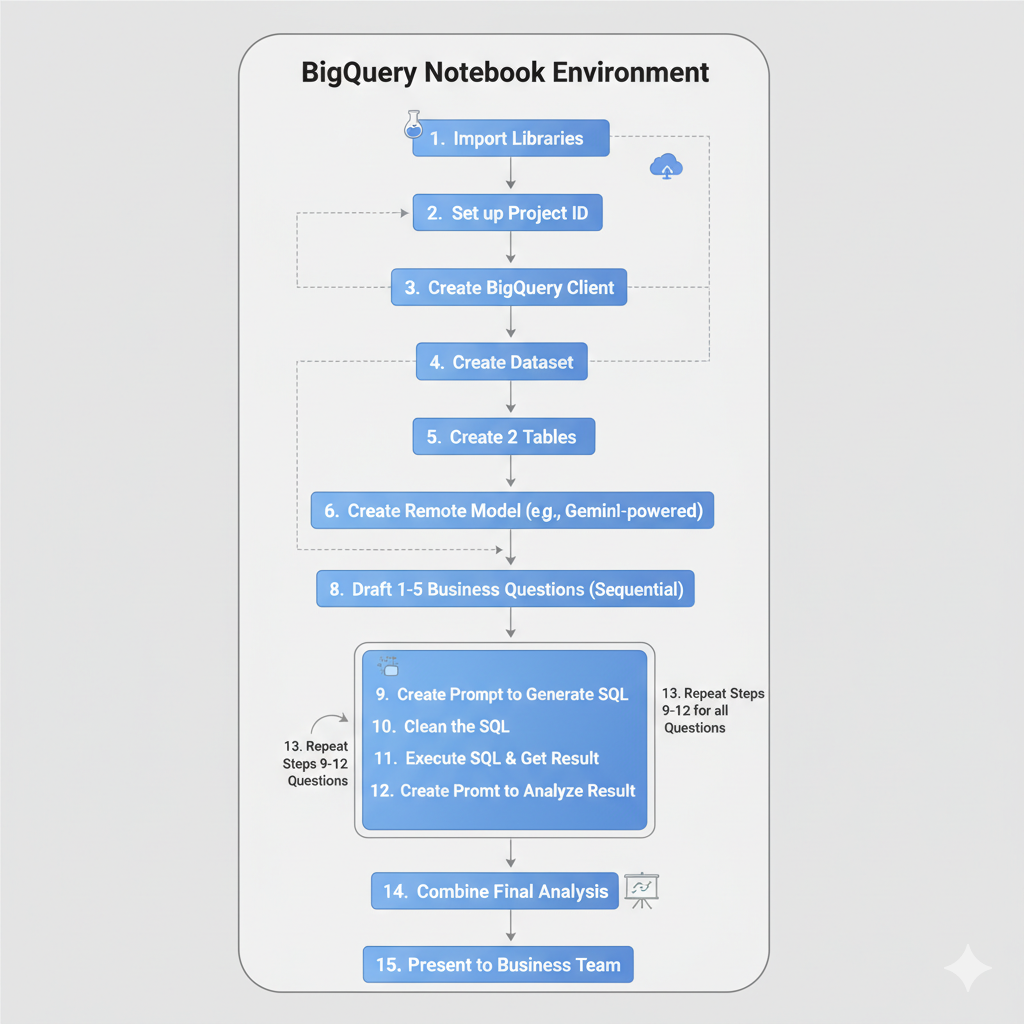

In [ ]:
# Import libraries
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.cloud import bigquery
import json
import io
from IPython.display import HTML, display
from pprint import pprint
import re
import pandas as pd

In [ ]:
# Set python variables for project_id and region
project_id = "kaggle-bq-ai" ##select your existing project
region = " us-central1"  ##select your region

In [ ]:
# create a bigquery client object
client = bigquery.Client(project="kaggle-bq-ai") ##update your existing project

In [ ]:
# following will create a BigQuery dataset called bq_ai_ds that will house the remote model
%%bigquery

CREATE SCHEMA
  `bq_ai_ds` OPTIONS (location = 'US');

In [ ]:
# We need to create 2 tables within this notebook. So update it before running the script.
table_pattern = "kaggle-bq-ai.bq_ai_ds.monthly_pattern_analysis"
table_by_cat = "kaggle-bq-ai.bq_ai_ds.daily_rev_by_cat_lst_2mth"

In [ ]:
# create a remote model for Gemini 2.0 Flash 001 model endpoint
# this remote model is saved in your bq_ai_ds dataset
%%bigquery
CREATE OR REPLACE MODEL `bq_ai_ds.gemini_pro`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'gemini-2.0-flash-001')

Providing an appropriate and detailed prompt is very important to get the desired output from the remote LLM model.
For this we are first going to create small chunks of text messages like

*   metadata info - This will have information on datatables, their relationship with each other, common base level filters etc
*   business formulas - to show the math for calculating KPIs / metrics
*   system instructions - They are like guardrails. Persona based for analyst and for data engineers

The above variables will be used throughout the notebook as per the business question and the role of the prompt. Hence better to declare it at the start

In [ ]:
## metadata_info will hold all the tables, their relationship with one another (ER), meaning of columns and all other info about the metadata
metadata_info = """
table name to query: `bigquery-public-data.thelook_ecommerce.order_items`, `bigquery-public-data.thelook_ecommerce.products`, `bigquery-public-data.thelook_ecommerce.orders`, `bigquery-public-data.thelook_ecommerce.users` If any table has been explicitly mentioned in the prompt then you can use that table.
columns that are needed: id, order_id, user_id, product_id, inventory_item_id, status, created_at from `bigquery-public-data.thelook_ecommerce.order_items`; category from `bigquery-public-data.thelook_ecommerce.products`; num_of_item from `bigquery-public-data.thelook_ecommerce.orders`
base condition to filter: created_at >= '2023-01-01 00:00:00 UTC', status = 'Complete'
entity relationship: Each order item refers to a specific product (order_items.product_id → products.id), One order can encompass multiple items (order_items.order_id → orders.order_id), One user can place multiple items (users.id → order_items.user_id)
created_at column means date of sale for the corresponding product_id
"""

In [ ]:
## what is the role of an analyst
system_instruction_as_analyst = """
You are an expert data analyst. Your task is to interpret data and provide insights that are valuable for business in less than 500 words. Do not include any personal opinions or extraneous details.
"""

In [ ]:
## what is the role of a data engineer
system_instruction_as_data_engineer = """
You are an expert in writing SQL using metadata info, revenue formula and business question. Your task is to create optimal SQLs that would run in bigquery.
"""

In [ ]:
## how is revenue calculated
revenue_formula = """
revenue = sale_price * num_of_item
"""

In [ ]:
## preliminary business questions that need to be answered. Total of 6 questions have been drafted
## These questions are mostly in sequential order such that question 1 will be at broad level.
## question 2 will be a offshoot of question 1 and so on....
business_question_1 = """
How much revenue are we making monthly?
Please answer it by creating following columns -
year_month and monthly_revenue
"""

In [ ]:
# Since question 1 will give monthly output, question 2 will check for any trend
business_question_2 = """
Is there any specific pattern in the revenue trend month on month?
Please highlight if you notice any.
Include Month & Year while presenting your findings.
"""

In [ ]:
# This questions only focuses on months where the trend is upward along with some extra dimensions
business_question_3 = """
I want to know which are the categories, brands from product table along with their revenue and date of sale. Also would like to know the user gender and country from the user table. Consider only last 2 months of period of increase for the latest year to answer this question.
"""

In [ ]:
# this question is for pareto analysis for subset data obtained from the previous question
business_question_4 = """
I wanted to know the total revenue generated per brand and its percentage contribution to the overall revenue. Kindly sort the data in decending order of total revenue.
"""

In [ ]:
# This is for interpreting the pareto
business_question_5 = """
I want to do a pareto analysis on the data provided.
Kindly answer how many brands contributed to 10% of the revenue.
If you notice any specific pattern then please highlight.
"""

For prompts that have to do number crunching, it is better to first create a SQL and obtain the result. Prompting over the results is better as it helps to get precise insights with less token consumption. Also the results are auditable as the enduser can always see the sql that was generated to give the resultant data and the insights

In [ ]:
##create a sql to answer business question 1. This will generate a SQL with all the system instructions and metadata
create_sql = """
SELECT
  ml_generate_text_result['candidates'][0]['content']['parts'][0]['text'] AS generated_sql
FROM
  ML.GENERATE_TEXT(
    MODEL `bq_ai_ds.gemini_pro`,
    (
      SELECT '''system_instructions: {sys_inst}
      business_question: {bus_q1}
      metadata: {meta}
      revenue formula: {rev}
      ''' AS prompt
    ),
    STRUCT(
      0.1 AS temperature,
      512 AS max_output_tokens
    )
  )
""".format(sys_inst = system_instruction_as_data_engineer.replace("'", "''"),bus_q1=business_question_1.replace("'", "''"),meta=metadata_info.replace("'", "''"),rev=revenue_formula.replace("'", "''"))


In [ ]:
# this is how the result looks
create_sql

In [ ]:
# store sql in df
gen_sql_df1 = client.query(create_sql).to_dataframe()

In [ ]:
gen_sql_df1

In [ ]:
## we need to clean this sql before executing it
# create a function to clean the sql
def clean_llm_sql(sql_df):
    # Extract the SQL string from the DataFrame
    sql_string = sql_df.iloc[0, 0]   # first row, first column

    # Remove code fences ```sql ... ```
    clean_sql = re.sub(r"```sql|```", "", sql_string).strip()

    # Replace escaped newlines (\n) with actual newlines
    clean_sql = clean_sql.replace("\\n", "\n")

    clean_strip_sql = clean_sql.strip().strip('"')


    return clean_strip_sql

In [ ]:
# Clean it
clean_sql = clean_llm_sql(gen_sql_df1)

In [ ]:
# Run the SQL and get result. Store it in df
result_df = client.query(clean_sql).to_dataframe()

In [ ]:
# this is the result
result_df

In [ ]:
# we will create a trend chart
result_df.plot(x="year_month", y="monthly_revenue", kind="line", marker="o", figsize=(10,5), title="Monthly Revenue Trend")

In [ ]:
# lets interpret this trend with the remote llm model. I am pasting the same business question 2 that we had earlier
business_question_2 = """
Is there any specific pattern in the revenue trend month on month?
Please highlight if you notice any.
Include Month & Year while presenting your findings.
"""

In [ ]:
# The data table obtained above needs to be converted to text for LLM
mth_rev_text = "\n".join([
    f"Month: {row.year_month}, Revenue: {row.monthly_revenue}"
    for row in result_df.itertuples(index=False)
])

In [ ]:
# this is how it looks now
mth_rev_text

In [ ]:
# Now we will get into the shoes of a analyst. Notice how the sys_inst have changed in the format arguments
# Analyse this data as a data analyst
query_rev_analysis = """
SELECT
  ml_generate_text_result['candidates'][0]['content']['parts'][0]['text'] AS generated_trend_analysis
FROM
  ML.GENERATE_TEXT(
    MODEL `bq_ai_ds.gemini_pro`,
    (
      SELECT '''system_instructions: {sys_inst}
      business_question: {bus_q}
      data: {llm_text}
      ''' AS prompt
    ),
    STRUCT(
      0.2 AS temperature,
      512 AS max_output_tokens
    )
  )
""".format(sys_inst = system_instruction_as_analyst.replace("'", "''"),bus_q=business_question_2.replace("'", "''"),llm_text=mth_rev_text.replace("'", "''"))

In [ ]:
# Lets check the prompt
query_rev_analysis

In [ ]:
# execute the prompt and store this in df
gen_da_trend_df = client.query(query_rev_analysis).to_dataframe()

In [ ]:
# check the response from the prompt
gen_da_trend_df

Since any trend analysis involves mostly 3 parts - uptrend, downtrend & stagnant, our followup query is to identify which periods fall under these 3 trends.

For this we will be creating a prompt to generate table by using AI.GENERATE_TABLE.

In [ ]:
# Add a 'prompt' column with instructions for the LLM
gen_da_trend_df['prompt'] = (
    "From the given text, extract the periods of revenue increase, decrease, stagnation and seasonality. "
    "Return a table with columns: period_of_increase, period_of_decrease, period_of_stagnation, period_of_seasonal_behaviour. "
    "Text: " + gen_da_trend_df['generated_trend_analysis']
)

In [ ]:
# this will create a new column in our dataframe for the prompt
gen_da_trend_df

In [ ]:
# To truncate and load, run the following. This will write truncate the table_pattern that you had declared earlier
job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE  # Overwrite table
)

In [ ]:
# Load dataframe into BigQuery
job = client.load_table_from_dataframe(gen_da_trend_df[['prompt']], table_pattern,job_config=job_config)
job.result()  # wait until finished

In [ ]:
# AI.GENERATE_TABLE needs to read data from a table, hence the previous step

query = f"""
SELECT period_of_decrease,
period_of_increase,
period_of_stagnation,
period_of_seasonal_behaviour
FROM AI.GENERATE_TABLE(
  MODEL `bq_ai_ds.gemini_pro`,
  (
    Select prompt as prompt FROM `kaggle-bq-ai.bq_ai_ds.monthly_pattern_analysis`
  ),
  STRUCT("period_of_increase STRING, period_of_decrease STRING, period_of_stagnation STRING, period_of_seasonal_behaviour STRING"
  AS output_schema, 1000 AS max_output_tokens)
  )
"""

result_df = client.query(query).to_dataframe()


In [ ]:
result_df

In [ ]:
## our next business query is derived from the response of result_df. It wants to
## analyse only the period of increase - especially last 2 months.
## So with the above result, we know and the prompt also knows which are the last 2 months
## from the period of increase
business_question_3 = """
I want to know which are the categories, brands from product table along with their revenue and date of sale. Also would like to know the user gender and country from the user table. Consider only last 2 months of period of increase for the latest year to answer this question.
"""

In [ ]:
period_of_increase = result_df['period_of_increase'].iloc[0]

In [ ]:
## time to create another promt to create an sql for the above question
create_sql_2 = """
SELECT
  ml_generate_text_result['candidates'][0]['content']['parts'][0]['text'] AS generated_sql
FROM
  ML.GENERATE_TEXT(
    MODEL `bq_ai_ds.gemini_pro`,
    (
      SELECT '''system_instructions: {sys_inst}
      business_question: {bus_q}
      metadata: {meta}
      revenue formula: {rev}
      period: {prd}
      ''' AS prompt
    ),
    STRUCT(
      0.1 AS temperature,
      512 AS max_output_tokens
    )
  )
""".format(sys_inst = system_instruction_as_data_engineer.replace("'", "''"),bus_q=business_question_3.replace("'", "''"),meta=metadata_info.replace("'", "''"),rev=revenue_formula.replace("'", "''"),prd=period_of_increase.replace("'", "''"))

In [ ]:
# store sql in df
gen_sql_df2 = client.query(create_sql_2).to_dataframe()

In [ ]:
# Clean it
clean_sql_2 = clean_llm_sql(gen_sql_df2)

In [ ]:
# Run the SQL and get result
result_rev_by_cat_df = client.query(clean_sql_2).to_dataframe()

In [ ]:
result_rev_by_cat_df

In [ ]:
# Load dataframe into BigQuery table that was declared on line 5 above
job = client.load_table_from_dataframe(result_rev_by_cat_df[['category','brand','revenue','sale_date','gender','country']], table_by_cat,job_config=job_config)
job.result()  # wait until finished

In [ ]:
# for the next business question, we will be using the table that we just created and loaded in BQ.
business_question_4 = """
I wanted to know the total revenue generated per brand and its percentage contribution to the overall revenue. Kindly sort the data in decending order of total revenue.
"""

In [ ]:
# Since data needs to be read from a bigquery table, the prompt style here is a bit different
prompt = f"""
Here is daily revenue data:

{table_by_cat}

Please create an sql for the following business question:
{business_question_4}

Follow these system_instructions:
{system_instruction_as_data_engineer}
"""

In [ ]:
# creat the sql to retrieve data for the above business question 4
create_sql_3 = f"""
SELECT
  ml_generate_text_result['candidates'][0]['content']['parts'][0]['text'] AS generated_sql
FROM ML.GENERATE_TEXT(
  MODEL `bq_ai_ds.gemini_pro`,
  (SELECT @prompt AS prompt),
  STRUCT(0.1 AS temperature, 512 AS max_output_tokens)
)
"""

In [ ]:
create_sql_3

In [ ]:
# set up the config for bq sql query job
job_config = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ScalarQueryParameter("prompt", "STRING", prompt)]
)

In [ ]:
# create a df for the generated sql
gen_par_sql_df3 = client.query(create_sql_3, job_config=job_config).to_dataframe()

In [ ]:
gen_par_sql_df3

In [ ]:
# Clean it
clean_par_sql = clean_llm_sql(gen_par_sql_df3)

In [ ]:
clean_par_sql

In [ ]:
# Run the SQL and get result
result_par_df = client.query(clean_par_sql).to_dataframe()

In [ ]:
# this is the pareto table
result_par_df

In [ ]:
# Convert to text for LLM
par_text = "\n".join([
    f"Brand: {row.brand}, has generated total revenue of: {row.total_revenue}, and has contribution of: {row.percentage_contribution} to the total revenue."
    for row in result_par_df.itertuples(index=False)
])

In [ ]:
# Once we have the data ready, we can analyse it. I have pasted the business question 5
business_question_5 = """
I want to do a pareto analysis on the data provided.
Kindly answer how many brands contributed to 10% of the revenue.
If you notice any specific pattern then please highlight.
"""

In [ ]:
# Analyse this data as a data analyst
pareto_analysis = """
SELECT
  ml_generate_text_result['candidates'][0]['content']['parts'][0]['text'] AS generated_pareto_analysis
FROM
  ML.GENERATE_TEXT(
    MODEL `bq_ai_ds.gemini_pro`,
    (
      SELECT '''system_instructions: {sys_inst}
      business_question: {bus_q}
      data: {llm_text}
      ''' AS prompt
    ),
    STRUCT(
      0.2 AS temperature,
      512 AS max_output_tokens
    )
  )
""".format(sys_inst = system_instruction_as_analyst.replace("'", "''"),bus_q=business_question_5.replace("'", "''"),llm_text=par_text.replace("'", "''"))

In [ ]:
# store analysis in df
gen_da_pareto_df = client.query(pareto_analysis).to_dataframe()

In [ ]:
gen_da_pareto_df

In [ ]:
# Finally we will combine both trend analysis and pareto analysis
# This can then be send to business teams as per their needs
#combine only the required columns
combined_analysis_df = pd.concat(
    [gen_da_trend_df[['generated_trend_analysis']], gen_da_pareto_df[['generated_pareto_analysis']]],
    axis=1
)

In [ ]:
combined_analysis_df